# Baselines

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# options of currency available

crypto_options = ['BTC','ETH','LTC'] # Bitcoing, Etherium, LiteCoin

In [3]:
crypto_choice  = input("Enter the currency : \n 1. BTC for Bitcoin \n 2. ETH for Etherium \n 3. LTC for Litecoin \n ")  

Enter the currency : 
 1. BTC for Bitcoin 
 2. ETH for Etherium 
 3. LTC for Litecoin 
 BTC


In [4]:
crypto_choice

'BTC'

In [6]:
# Bitcoin

data_path = '/Users/nesarasr/Documents/CryptoPy/Data/Binance_' + crypto_choice + 'USDT_d.csv'

In [7]:
data_path

In [8]:
df = pd.read_csv(data_path)
df['Volume'] = df['Volume '+crypto_choice]

In [9]:
df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,Volume
0,1502928000,2017-08-17,BTCUSDT,4469.93,4485.39,4200.74,4285.08,647.86,2812379.11,647.86
1,1503014400,2017-08-18,BTCUSDT,4285.08,4371.52,3938.77,4108.37,1178.07,4994493.56,1178.07
2,1503100800,2017-08-19,BTCUSDT,4108.37,4184.69,3850.00,4139.98,371.15,1508239.39,371.15
3,1503187200,2017-08-20,BTCUSDT,4139.98,4211.08,4032.62,4086.29,463.54,1915636.35,463.54
4,1503273600,2017-08-21,BTCUSDT,4086.29,4119.62,3911.79,4016.00,685.12,2770592.06,685.12


# Preparing dataset for multivariate : technical indicator features

In [10]:
def moving_average(df, n):
    """Calculate the moving average for the given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


def momentum(df, n):
    """
    
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df


def average_true_range(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    df = df.join(ATR)
    return df


def bollinger_bands(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df


def ppsr(df):
    """Calculate Pivot Points, Supports and Resistances for given data
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)
    R1 = pd.Series(2 * PP - df['Low'])
    S1 = pd.Series(2 * PP - df['High'])
    R2 = pd.Series(PP + df['High'] - df['Low'])
    S2 = pd.Series(PP - df['High'] + df['Low'])
    R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))
    S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))
    psr = {'PP': PP, 'R1': R1, 'S1': S1, 'R2': R2, 'S2': S2, 'R3': R3, 'S3': S3}
    PSR = pd.DataFrame(psr)
    df = df.join(PSR)
    return df


def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df


def trix(df, n):
    """Calculate TRIX for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EX1 = df['Close'].ewm(span=n, min_periods=n).mean()
    EX2 = EX1.ewm(span=n, min_periods=n).mean()
    EX3 = EX2.ewm(span=n, min_periods=n).mean()
    i = 0
    ROC_l = [np.nan]
    while i + 1 <= df.index[-1]:
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
        ROC_l.append(ROC)
        i = i + 1
    Trix = pd.Series(ROC_l, name='Trix_' + str(n))
    df = df.join(Trix)
    return df


def average_directional_movement_index(df, n, n_ADX):
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    df = df.join(ADX)
    return df


def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def mass_index(df):
    """Calculate the Mass Index for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    Range = df['High'] - df['Low']
    EX1 = Range.ewm(span=9, min_periods=9).mean()
    EX2 = EX1.ewm(span=9, min_periods=9).mean()
    Mass = EX1 / EX2
    MassI = pd.Series(Mass.rolling(25).sum(), name='Mass Index')
    df = df.join(MassI)
    return df


def vortex_indicator(df, n):
    """Calculate the Vortex Indicator for given data.
    
    Vortex Indicator described here:
        http://www.vortexindicator.com/VFX_VORTEX.PDF
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR = [0]
    while i < df.index[-1]:
        Range = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.loc[i + 1, 'High'] - df.loc[i, 'Low']) - abs(df.loc[i + 1, 'Low'] - df.loc[i, 'High'])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
    df = df.join(VI)
    return df


def kst_oscillator(df, r1, r2, r3, r4, n1, n2, n3, n4):
    """Calculate KST Oscillator for given data.
    
    :param df: pandas.DataFrame
    :param r1: 
    :param r2: 
    :param r3: 
    :param r4: 
    :param n1: 
    :param n2: 
    :param n3: 
    :param n4: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(r1 - 1)
    N = df['Close'].shift(r1 - 1)
    ROC1 = M / N
    M = df['Close'].diff(r2 - 1)
    N = df['Close'].shift(r2 - 1)
    ROC2 = M / N
    M = df['Close'].diff(r3 - 1)
    N = df['Close'].shift(r3 - 1)
    ROC3 = M / N
    M = df['Close'].diff(r4 - 1)
    N = df['Close'].shift(r4 - 1)
    ROC4 = M / N
    KST = pd.Series(
        ROC1.rolling(n1).sum() + ROC2.rolling(n2).sum() * 2 + ROC3.rolling(n3).sum() * 3 + ROC4.rolling(n4).sum() * 4,
        name='KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(
            n2) + '_' + str(n3) + '_' + str(n4))
    df = df.join(KST)
    return df


def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df


def true_strength_index(df, r, s):
    """Calculate True Strength Index (TSI) for given data.
    
    :param df: pandas.DataFrame
    :param r: 
    :param s: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(1))
    aM = abs(M)
    EMA1 = pd.Series(M.ewm(span=r, min_periods=r).mean())
    aEMA1 = pd.Series(aM.ewm(span=r, min_periods=r).mean())
    EMA2 = pd.Series(EMA1.ewm(span=s, min_periods=s).mean())
    aEMA2 = pd.Series(aEMA1.ewm(span=s, min_periods=s).mean())
    TSI = pd.Series(EMA2 / aEMA2, name='TSI_' + str(r) + '_' + str(s))
    df = df.join(TSI)
    return df


def accumulation_distribution(df, n):
    """Calculate Accumulation/Distribution for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
    df = df.join(AD)
    return df


def chaikin_oscillator(df):
    """Calculate Chaikin Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    Chaikin = pd.Series(ad.ewm(span=3, min_periods=3).mean() - ad.ewm(span=10, min_periods=10).mean(), name='Chaikin')
    df = df.join(Chaikin)
    return df


def money_flow_index(df, n):
    """Calculate Money Flow Index and Ratio for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    while i < df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.loc[i + 1, 'Volume'])
        else:
            PosMF.append(0)
        i = i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    MFI = pd.Series(MFR.rolling(n, min_periods=n).mean(), name='MFI_' + str(n))
    df = df.join(MFI)
    return df


def on_balance_volume(df, n):
    """Calculate On-Balance Volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    while i < df.index[-1]:
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    df = df.join(OBV_ma)
    return df


def force_index(df, n):
    """Calculate Force Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name='Force_' + str(n))
    df = df.join(F)
    return df


def ease_of_movement(df, n):
    """Calculate Ease of Movement for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])
    Eom_ma = pd.Series(EoM.rolling(n, min_periods=n).mean(), name='EoM_' + str(n))
    df = df.join(Eom_ma)
    return df


def commodity_channel_index(df, n):
    """Calculate Commodity Channel Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df


def coppock_curve(df, n):
    """Calculate Coppock Curve for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(int(n * 11 / 10) - 1)
    N = df['Close'].shift(int(n * 11 / 10) - 1)
    ROC1 = M / N
    M = df['Close'].diff(int(n * 14 / 10) - 1)
    N = df['Close'].shift(int(n * 14 / 10) - 1)
    ROC2 = M / N
    Copp = pd.Series((ROC1 + ROC2).ewm(span=n, min_periods=n).mean(), name='Copp_' + str(n))
    df = df.join(Copp)
    return df


def keltner_channel(df, n):
    """Calculate Keltner Channel for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChM_' + str(n))
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChU_' + str(n))
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChD_' + str(n))
    df = df.join(KelChM)
    df = df.join(KelChU)
    df = df.join(KelChD)
    return df


def ultimate_oscillator(df):
    """Calculate Ultimate Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    BP_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        BP = df.loc[i + 1, 'Close'] - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        BP_l.append(BP)
        i = i + 1
    UltO = pd.Series((4 * pd.Series(BP_l).rolling(7).sum() / pd.Series(TR_l).rolling(7).sum()) + (
                2 * pd.Series(BP_l).rolling(14).sum() / pd.Series(TR_l).rolling(14).sum()) + (
                                 pd.Series(BP_l).rolling(28).sum() / pd.Series(TR_l).rolling(28).sum()),
                     name='Ultimate_Osc')
    df = df.join(UltO)
    return df


def donchian_channel(df, n):
    """Calculate donchian channel of given pandas data frame.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    dc_l = []
    while i < n - 1:
        dc_l.append(0)
        i += 1

    i = 0
    while i + n - 1 < df.index[-1]:
        dc = max(df['High'].iloc[i:i + n - 1]) - min(df['Low'].iloc[i:i + n - 1])
        dc_l.append(dc)
        i += 1

    donchian_chan = pd.Series(dc_l, name='Donchian_' + str(n))
    donchian_chan = donchian_chan.shift(n - 1)
    return df.join(donchian_chan)


def standard_deviation(df, n):
    """Calculate Standard Deviation for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    df = df.join(pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n)))
    return df

In [11]:
df = moving_average(df, 10)
df = exponential_moving_average(df, 10)
df = momentum(df, 10)
df = rate_of_change(df, 10)
df = average_true_range(df, 10)
df = bollinger_bands(df, 10)
df = ppsr(df)
df = stochastic_oscillator_k(df)
df = stochastic_oscillator_d(df, 10)
df = trix(df, 10)
df = average_directional_movement_index(df, 10, 25)
df = macd(df, 10, 50)
df = mass_index(df)
df = vortex_indicator(df, 10)
df = kst_oscillator(df,10,15, 20, 30, 1, 2, 3, 4)
df = relative_strength_index(df, 10)
df = true_strength_index(df,10,20)
df = accumulation_distribution(df, 10)
df = chaikin_oscillator(df)
df = money_flow_index(df, 10)
df = on_balance_volume(df, 10)
df = force_index(df, 10)
df = ease_of_movement(df, 10)
df = commodity_channel_index(df, 10)
df = coppock_curve(df, 10)
df = keltner_channel(df, 10)
df = ultimate_oscillator(df)
df = donchian_channel(df, 10)
df = standard_deviation(df, 10)


In [12]:
df = df.replace([np.inf, -np.inf], np.nan)

df = df.fillna(df.mean())


In [13]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = df.drop(['Unix Timestamp','Date','Symbol'],axis=1)
values = dataset.values

In [14]:
dataset

,Open,High,Low,Close,Volume BTC,Volume USDT,Volume,MA_10,EMA_10,Momentum_10,ROC_10,ATR_10,BollingerB_10,Bollinger%b_10,PP,R1,S1,R2,S2,R3,S3,SO%k,SO%d_10,Trix_10,ADX_10_25,MACD_10_50,MACDsign_10_50,MACDdiff_10_50,Mass Index,Vortex_10,KST_10_15_20_30_1_2_3_4,RSI_10,TSI_10_20,Acc/Dist_ROC_10,Chaikin,MFI_10,OBV_10,Force_10,EoM_10,CCI_10,Copp_10,KelChM_10,KelChU_10,KelChD_10,Ultimate_Osc,Donchian_10,STD_10
0,4469.93,4485.39,4200.74,4285.08,647.86,2.812379e+06,647.86,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4323.736667,4446.733333,4162.083333,4608.386667,4039.086667,4731.383333,3877.433333,0.296294,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
1,4285.08,4371.52,3938.77,4108.37,1178.07,4.994494e+06,1178.07,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4139.553333,4340.336667,3907.586667,4572.303333,3706.803333,4773.086667,3474.836667,0.391912,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
2,4108.37,4184.69,3850.00,4139.98,371.15,1.508239e+06,371.15,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4058.223333,4266.446667,3931.756667,4392.913333,3723.533333,4601.136667,3597.066667,0.866414,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
3,4139.98,4211.08,4032.62,4086.29,463.54,1.915636e+06,463.54,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4109.996667,4187.373333,4008.913333,4288.456667,3931.536667,4365.833333,3830.453333,0.300740,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
4,4086.29,4119.62,3911.79,4016.00,685.12,2.770592e+06,685.12,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4015.803333,4119.816667,3911.986667,4223.633333,3807.973333,4327.646667,3704.156667,0.501419,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,15957.00,16880.00,15864.00,16713.57,81300.68,1.335728e+09,81300.68,15795.68400,15808.528591,1133.650000,0.127901,750.440307,0.146282,0.897247,16485.856667,17107.713333,16091.713333,17501.856667,15469.856667,18123.713333,15075.713333,0.836191,0.667415,0.011304,0.551728,2274.035905,2091.140165,182.895739,27.792780,0.202866,9.681470,0.803412,0.485070,-2.647059,4385.781986,0.600000,2840.320000,-4.683961e+07,0.582448,1.529340,0.285498,15724.451333,16522.023333,14926.879333,4.925967,3039.230000,577.654357
1176,16713.57,17858.82,16538.00,17659.38,115221.40,1.982752e+09,115221.40,16079.79200,16145.047029,2841.080000,0.141148,854.145706,0.180035,1.045641,17352.066667,18166.133333,16845.313333,18672.886667,16031.246667,19486.953333,15524.493333,0.849003,0.700431,0.011584,0.572329,2448.794056,2162.670943,286.123112,27.692458,0.545068,10.474378,0.881946,0.515963,0.946727,18683.837649,0.700000,24505.581000,3.917903e+07,2.244128,2.153541,0.313638,15962.456667,16751.180667,15173.732667,5.103704,2845.0

In [15]:
dataset.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume BTC', 'Volume USDT', 'Volume',
       'MA_10', 'EMA_10', 'Momentum_10', 'ROC_10', 'ATR_10', 'BollingerB_10',
       'Bollinger%b_10', 'PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3', 'SO%k',
       'SO%d_10', 'Trix_10', 'ADX_10_25', 'MACD_10_50', 'MACDsign_10_50',
       'MACDdiff_10_50', 'Mass Index', 'Vortex_10', 'KST_10_15_20_30_1_2_3_4',
       'RSI_10', 'TSI_10_20', 'Acc/Dist_ROC_10', 'Chaikin', 'MFI_10', 'OBV_10',
       'Force_10', 'EoM_10', 'CCI_10', 'Copp_10', 'KelChM_10', 'KelChU_10',
       'KelChD_10', 'Ultimate_Osc', 'Donchian_10', 'STD_10'],
      dtype='object')

In [16]:
y = dataset['Close']
X = dataset.drop(['Close'],axis=1)

In [17]:
X = X.join(y)

In [18]:
X

,Open,High,Low,Volume BTC,Volume USDT,Volume,MA_10,EMA_10,Momentum_10,ROC_10,ATR_10,BollingerB_10,Bollinger%b_10,PP,R1,S1,R2,S2,R3,S3,SO%k,SO%d_10,Trix_10,ADX_10_25,MACD_10_50,MACDsign_10_50,MACDdiff_10_50,Mass Index,Vortex_10,KST_10_15_20_30_1_2_3_4,RSI_10,TSI_10_20,Acc/Dist_ROC_10,Chaikin,MFI_10,OBV_10,Force_10,EoM_10,CCI_10,Copp_10,KelChM_10,KelChU_10,KelChD_10,Ultimate_Osc,Donchian_10,STD_10,Close
0,4469.93,4485.39,4200.74,647.86,2.812379e+06,647.86,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4323.736667,4446.733333,4162.083333,4608.386667,4039.086667,4731.383333,3877.433333,0.296294,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242,4285.08
1,4285.08,4371.52,3938.77,1178.07,4.994494e+06,1178.07,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4139.553333,4340.336667,3907.586667,4572.303333,3706.803333,4773.086667,3474.836667,0.391912,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242,4108.37
2,4108.37,4184.69,3850.00,371.15,1.508239e+06,371.15,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4058.223333,4266.446667,3931.756667,4392.913333,3723.533333,4601.136667,3597.066667,0.866414,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242,4139.98
3,4139.98,4211.08,4032.62,463.54,1.915636e+06,463.54,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4109.996667,4187.373333,4008.913333,4288.456667,3931.536667,4365.833333,3830.453333,0.300740,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242,4086.29
4,4086.29,4119.62,3911.79,685.12,2.770592e+06,685.12,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4015.803333,4119.816667,3911.986667,4223.633333,3807.973333,4327.646667,3704.156667,0.501419,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242,4016.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,15957.00,16880.00,15864.00,81300.68,1.335728e+09,81300.68,15795.68400,15808.528591,1133.650000,0.127901,750.440307,0.146282,0.897247,16485.856667,17107.713333,16091.713333,17501.856667,15469.856667,18123.713333,15075.713333,0.836191,0.667415,0.011304,0.551728,2274.035905,2091.140165,182.895739,27.792780,0.202866,9.681470,0.803412,0.485070,-2.647059,4385.781986,0.600000,2840.320000,-4.683961e+07,0.582448,1.529340,0.285498,15724.451333,16522.023333,14926.879333,4.925967,3039.230000,577.654357,16713.57
1176,16713.57,17858.82,16538.00,115221.40,1.982752e+09,115221.40,16079.79200,16145.047029,2841.080000,0.141148,854.145706,0.180035,1.045641,17352.066667,18166.133333,16845.313333,18672.886667,16031.246667,19486.953333,15524.493333,0.849003,0.700431,0.011584,0.572329,2448.794056,2162.670943,286.123112,27.692458,0.545068,10.474378,0.881946,0.515963,0.946727,18683.837649,0.700000,24505.581000,3.917903e+07,2.244128,2.153541,0.313638,15962.456667,16751.180667,15173.732667,5.103704,2845.000000,723

In [19]:
values = X.values

In [20]:

values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 7
n_features = 46
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)



(1173, 376)


In [21]:
reframed.shape[0]

1173

In [22]:

# split into train and test sets
values = reframed.values
n_train_hours = reframed.shape[0]
train = values[:int(0.9*n_train_hours), :]
test = values[int(0.9*n_train_hours):, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)



(1055, 322) 1055 (1055,)


# LSTM

In [23]:
# reshape input to be 3D [samples, timesteps, features]
train_X_lstm = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X_lstm = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X_lstm.shape, train_y.shape, test_X_lstm.shape, test_y.shape)

(1055, 7, 46) (1055,) (118, 7, 46) (118,)


In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X_lstm, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)



Epoch 1/50
15/15 - 0s - loss: 0.1568
Epoch 2/50
15/15 - 0s - loss: 0.0608
Epoch 3/50
15/15 - 0s - loss: 0.0427
Epoch 4/50
15/15 - 0s - loss: 0.0367
Epoch 5/50
15/15 - 0s - loss: 0.0295
Epoch 6/50
15/15 - 0s - loss: 0.0254
Epoch 7/50
15/15 - 0s - loss: 0.0313
Epoch 8/50
15/15 - 0s - loss: 0.0330
Epoch 9/50
15/15 - 0s - loss: 0.0370
Epoch 10/50
15/15 - 0s - loss: 0.0354
Epoch 11/50
15/15 - 0s - loss: 0.0329
Epoch 12/50
15/15 - 0s - loss: 0.0259
Epoch 13/50
15/15 - 0s - loss: 0.0315
Epoch 14/50
15/15 - 0s - loss: 0.0307
Epoch 15/50
15/15 - 0s - loss: 0.0256
Epoch 16/50
15/15 - 0s - loss: 0.0205
Epoch 17/50
15/15 - 0s - loss: 0.0244
Epoch 18/50
15/15 - 0s - loss: 0.0276
Epoch 19/50
15/15 - 0s - loss: 0.0247
Epoch 20/50
15/15 - 0s - loss: 0.0247
Epoch 21/50
15/15 - 0s - loss: 0.0268
Epoch 22/50
15/15 - 0s - loss: 0.0260
Epoch 23/50
15/15 - 0s - loss: 0.0217
Epoch 24/50
15/15 - 0s - loss: 0.0177
Epoch 25/50
15/15 - 0s - loss: 0.0236
Epoch 26/50
15/15 - 0s - loss: 0.0244
Epoch 27/50
15/15 - 0

In [25]:
# make a prediction
yhat_lstm = model.predict(test_X_lstm)
test_X_lstm = test_X_lstm.reshape((test_X_lstm.shape[0], n_hours*n_features))

In [26]:
test_X_lstm.shape

(118, 322)

In [27]:
# invert scaling for forecast
inv_yhat = concatenate((yhat_lstm, test_X_lstm[:, -46:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual

In [28]:
test_y_lstm = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_lstm, test_X_lstm[:, -46:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [29]:
#Various metrics for Error Evaluation on inverted scaled data

#Determining Mean Squared Error in a given LSTM model
MSE1=mean_squared_error(inv_yhat,inv_y)
print("Mean Squared Error for LSTM model:",MSE1)

#Determing R-Squared Error in a given LSTM model
R21=r2_score(yhat_lstm,test_y)
print("R-squared Error for LSTM model:",R21)

#Determining Mean Absolute Error in a given LSTM model
MAE1=mean_absolute_error(yhat_lstm,test_y)
print("Mean Absolute Error for LSTM model:",MAE1)

#Determing Root Mean Squared Error in a given LSTM model
RMS1=math.sqrt(MSE1)
print("Root Mean Squared Error for LSTM model:",RMS1)

Mean Squared Error for LSTM model: 214950.03
R-squared Error for LSTM model: 0.9153249372186992
Mean Absolute Error for LSTM model: 0.018092642
Root Mean Squared Error for LSTM model: 463.62703895480473


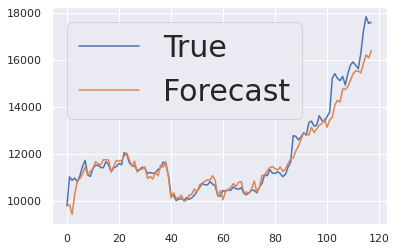

In [30]:
plt.plot(inv_y,label='True')
plt.plot(inv_yhat,label='Forecast')
fig_size=(20,10)
plt.rcParams["figure.figsize"] = fig_size
plt.legend(loc='best',prop={'size': 30}) 
plt.show()

# Random Forest

In [31]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1055, 322) (1055,) (118, 322) (118,)


In [32]:
train_X_rf = train_X
test_X_rf = test_X

In [33]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [34]:
yhat_rf = regr.predict(test_X_rf)

In [35]:
yhat_rf.shape

(118,)

In [36]:
test_X_rf.shape

(118, 322)

In [37]:
yhat_rf = yhat_rf.reshape((-1,1))

In [38]:
# invert scaling for forecast
inv_yhat = concatenate((yhat_rf, test_X_rf[:, -46:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual

In [39]:
test_y_rf = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_rf, test_X_rf[:, -46:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]



In [40]:
#Various metrics for Error Evaluation on inverted scaled

#Determining Mean Squared Error in a given Random Forest model
MSE2=mean_squared_error(inv_yhat,inv_y)
print("Mean Squared Error for Random Forest model:",MSE2)

#Determing R-Squared Error in a given Random Forest model
R22=r2_score(inv_yhat,inv_y)
print("R-squared Error for Random Forest model:",R22)

#Determining Mean Absolute Error in a given Random Forest model
MAE2=mean_absolute_error(inv_yhat,inv_y)
print("Mean Absolute Error for Random Forest model:",MAE2)

#Determing Root Mean Squared Error in a given Random Forest model
RMS2=math.sqrt(MSE2)
print("Root Mean Squared Error for Random Forest model:",RMS2)

Mean Squared Error for Random Forest model: 266593.081500324
R-squared Error for Random Forest model: 0.9182717668834733
Mean Absolute Error for Random Forest model: 317.5393863847241
Root Mean Squared Error for Random Forest model: 516.3265260475429


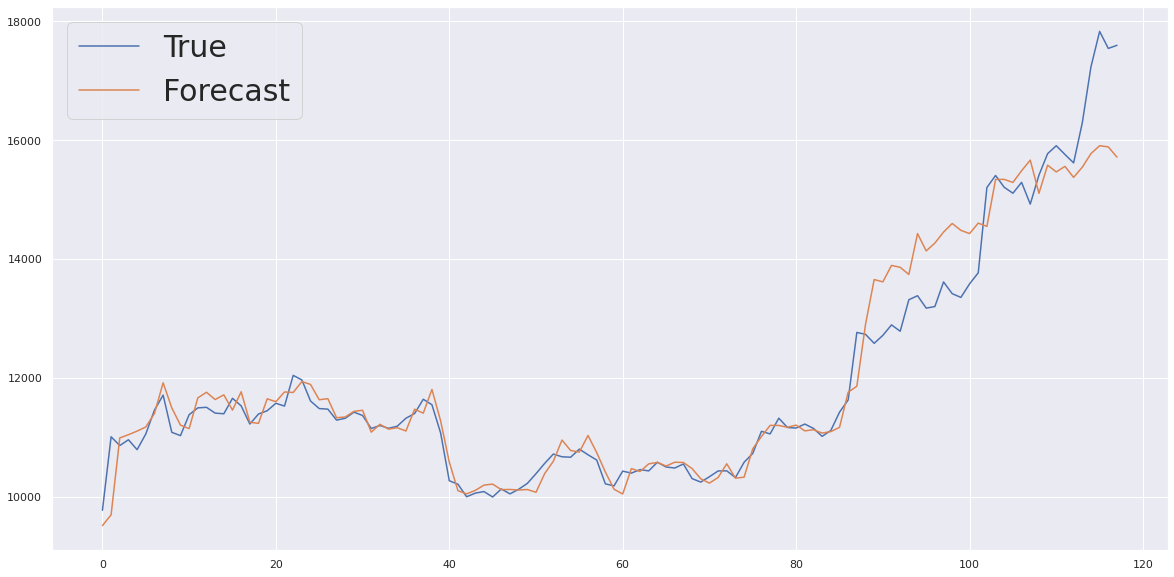

In [41]:
plt.plot(inv_y,label='True')
plt.plot(inv_yhat,label='Forecast')
fig_size=(20,10)
plt.rcParams["figure.figsize"] = fig_size
plt.legend(loc='best',prop={'size': 30}) 
plt.show()

# CNN

In [42]:
# reshape input to be 3D [samples, timesteps, features]
train_X_cnn = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X_cnn = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X_cnn.shape, train_y.shape, test_X_cnn.shape, test_y.shape)

(1055, 7, 46) (1055,) (118, 7, 46) (118,)


In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Conv1D
from numpy import concatenate


# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_hours, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [44]:
model.fit(train_X_cnn, train_y, epochs=50, verbose=2)

Epoch 1/50
33/33 - 0s - loss: 0.0558
Epoch 2/50
33/33 - 0s - loss: 0.0050
Epoch 3/50
33/33 - 0s - loss: 0.0030
Epoch 4/50
33/33 - 0s - loss: 0.0023
Epoch 5/50
33/33 - 0s - loss: 0.0019
Epoch 6/50
33/33 - 0s - loss: 0.0016
Epoch 7/50
33/33 - 0s - loss: 0.0014
Epoch 8/50
33/33 - 0s - loss: 0.0012
Epoch 9/50
33/33 - 0s - loss: 0.0011
Epoch 10/50
33/33 - 0s - loss: 0.0012
Epoch 11/50
33/33 - 0s - loss: 9.9845e-04
Epoch 12/50
33/33 - 0s - loss: 0.0010
Epoch 13/50
33/33 - 0s - loss: 9.2390e-04
Epoch 14/50
33/33 - 0s - loss: 8.9307e-04
Epoch 15/50
33/33 - 0s - loss: 7.9265e-04
Epoch 16/50
33/33 - 0s - loss: 6.8273e-04
Epoch 17/50
33/33 - 0s - loss: 6.7588e-04
Epoch 18/50
33/33 - 0s - loss: 6.3831e-04
Epoch 19/50
33/33 - 0s - loss: 6.0627e-04
Epoch 20/50
33/33 - 0s - loss: 5.7998e-04
Epoch 21/50
33/33 - 0s - loss: 5.5162e-04
Epoch 22/50
33/33 - 0s - loss: 5.2718e-04
Epoch 23/50
33/33 - 0s - loss: 5.2068e-04
Epoch 24/50
33/33 - 0s - loss: 5.4514e-04
Epoch 25/50
33/33 - 0s - loss: 4.7143e-04
Epo

In [45]:
# make a prediction
yhat_cnn = model.predict(test_X_cnn)
test_X_cnn = test_X_cnn.reshape((test_X_cnn.shape[0], n_hours*n_features))

In [46]:
# invert scaling for forecast
inv_yhat = concatenate((yhat_cnn, test_X_cnn[:, -46:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual

In [48]:
test_y_cnn = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_cnn, test_X_cnn[:, -46:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [49]:
#Various metrics for Error Evaluation on inverted scaled data

#Determining Mean Squared Error in a given CNN model
MSE3=mean_squared_error(inv_yhat,inv_y)
print("Mean Squared Error for CNN model:",MSE3)

#Determing R-Squared Error in a given CNN model
R23=r2_score(inv_yhat,inv_y)
print("R-squared Error for CNN model:",R23)

#Determining Mean Absolute Error in a given CNN model
MAE3=mean_absolute_error(inv_yhat,inv_y)
print("Mean Absolute Error for CNN model:",MAE3)

#Determing Root Mean Squared Error in a given CNN model
RMS3=math.sqrt(MSE3)
print("Root Mean Squared Error for CNN model:",RMS3)

Mean Squared Error for CNN model: 164431.78
R-squared Error for CNN model: 0.9474038483174227
Mean Absolute Error for CNN model: 321.44186
Root Mean Squared Error for CNN model: 405.501888096714


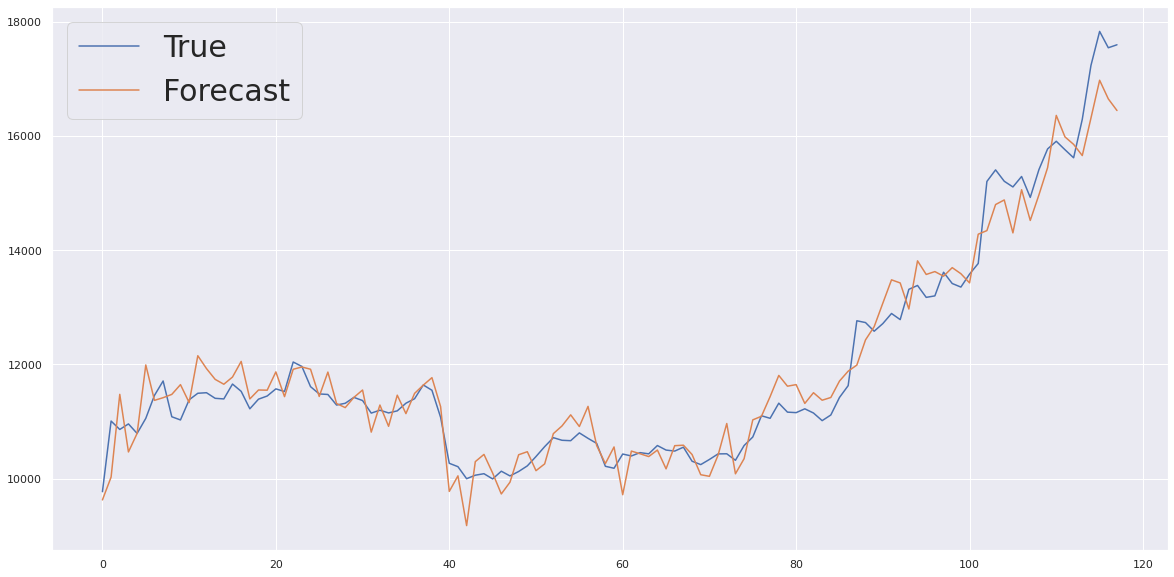

In [50]:
plt.plot(inv_y,label='True')
plt.plot(inv_yhat,label='Forecast')
fig_size=(20,10)
plt.rcParams["figure.figsize"] = fig_size
plt.legend(loc='best',prop={'size': 30}) 
plt.show()

# Univariate

In [51]:
dataset

,Open,High,Low,Close,Volume BTC,Volume USDT,Volume,MA_10,EMA_10,Momentum_10,ROC_10,ATR_10,BollingerB_10,Bollinger%b_10,PP,R1,S1,R2,S2,R3,S3,SO%k,SO%d_10,Trix_10,ADX_10_25,MACD_10_50,MACDsign_10_50,MACDdiff_10_50,Mass Index,Vortex_10,KST_10_15_20_30_1_2_3_4,RSI_10,TSI_10_20,Acc/Dist_ROC_10,Chaikin,MFI_10,OBV_10,Force_10,EoM_10,CCI_10,Copp_10,KelChM_10,KelChU_10,KelChD_10,Ultimate_Osc,Donchian_10,STD_10
0,4469.93,4485.39,4200.74,4285.08,647.86,2.812379e+06,647.86,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4323.736667,4446.733333,4162.083333,4608.386667,4039.086667,4731.383333,3877.433333,0.296294,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
1,4285.08,4371.52,3938.77,4108.37,1178.07,4.994494e+06,1178.07,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4139.553333,4340.336667,3907.586667,4572.303333,3706.803333,4773.086667,3474.836667,0.391912,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
2,4108.37,4184.69,3850.00,4139.98,371.15,1.508239e+06,371.15,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4058.223333,4266.446667,3931.756667,4392.913333,3723.533333,4601.136667,3597.066667,0.866414,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
3,4139.98,4211.08,4032.62,4086.29,463.54,1.915636e+06,463.54,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4109.996667,4187.373333,4008.913333,4288.456667,3931.536667,4365.833333,3830.453333,0.300740,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
4,4086.29,4119.62,3911.79,4016.00,685.12,2.770592e+06,685.12,8146.53412,8148.176933,108.275453,0.019528,505.229630,0.191082,0.534215,4015.803333,4119.816667,3911.986667,4223.633333,3807.973333,4327.646667,3704.156667,0.501419,0.554504,0.001108,0.434213,163.016882,155.123481,7.537652,24.947317,0.055568,1.564472,0.514813,0.046680,0.754281,71.439049,0.528063,2530.200566,-2.566860e+06,2.192107,0.145763,0.048036,8127.524416,8632.627213,7622.421618,3.819251,1575.929274,402.343242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,15957.00,16880.00,15864.00,16713.57,81300.68,1.335728e+09,81300.68,15795.68400,15808.528591,1133.650000,0.127901,750.440307,0.146282,0.897247,16485.856667,17107.713333,16091.713333,17501.856667,15469.856667,18123.713333,15075.713333,0.836191,0.667415,0.011304,0.551728,2274.035905,2091.140165,182.895739,27.792780,0.202866,9.681470,0.803412,0.485070,-2.647059,4385.781986,0.600000,2840.320000,-4.683961e+07,0.582448,1.529340,0.285498,15724.451333,16522.023333,14926.879333,4.925967,3039.230000,577.654357
1176,16713.57,17858.82,16538.00,17659.38,115221.40,1.982752e+09,115221.40,16079.79200,16145.047029,2841.080000,0.141148,854.145706,0.180035,1.045641,17352.066667,18166.133333,16845.313333,18672.886667,16031.246667,19486.953333,15524.493333,0.849003,0.700431,0.011584,0.572329,2448.794056,2162.670943,286.123112,27.692458,0.545068,10.474378,0.881946,0.515963,0.946727,18683.837649,0.700000,24505.581000,3.917903e+07,2.244128,2.153541,0.313638,15962.456667,16751.180667,15173.732667,5.103704,2845.0

In [52]:
x = dataset['Close']



In [53]:
train = np.reshape(np.array(x[:int(0.9*len(x))]),(-1,1))
test = np.reshape(np.array(x[int(0.9*len(x)):]),(-1,1))

In [54]:
train.shape

(1062, 1)

In [55]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))


train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [56]:
def split_sequence(sequence,n_steps):
    X=[]
    y=[]
    for i in range((sequence.size)):
        end_ix=i+n_steps
        if end_ix> (sequence.size)-1:
            break
        seq_x,seq_y=sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

In [57]:
X_train, y_train = split_sequence(np.array(train_scaled),10)
X_test, y_test = split_sequence(np.array(test_scaled),10)

In [58]:
BATCH_SIZE = 72
BUFFER_SIZE = 200

train_univariate = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_univariate = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_univariate = test_univariate.batch(BATCH_SIZE).repeat()

In [59]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [60]:
EVALUATION_INTERVAL = 100
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0572
Epoch 2/10
100/100 [==============================] - 1s 5ms/step - loss: 0.0298
Epoch 3/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0259
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0238
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0217
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0200
Epoch 7/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0196
Epoch 8/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0184
Epoch 9/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0175
Epoch 10/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0171


In [61]:
# make a prediction
yhat = simple_lstm_model.predict(X_test)


In [62]:
inv_yhat = scaler.inverse_transform(yhat)

In [63]:
inv_y = scaler.inverse_transform(y_test)


In [64]:
#Various metrics for Error Evaluation on inverted scaled data

#Determining Mean Squared Error in a given model
MSE4=mean_squared_error(inv_yhat,inv_y)
print("Mean Squared Error for given model:",MSE4)

#Determing R-Squared Error in a given model
R24=r2_score(inv_yhat,inv_y)
print("R-squared Error for given model:",R24)

#Determining Mean Absolute Error in a given model
MAE4=mean_absolute_error(inv_yhat,inv_y)
print("Mean Absolute Error for given model:",MAE4)

#Determing Root Mean Squared Error in a given model
RMS4=math.sqrt(MSE4)
print("Root Mean Squared Error for given model:",RMS4)

Mean Squared Error for given model: 225799.17096794228
R-squared Error for given model: 0.928629518996478
Mean Absolute Error for given model: 355.484283130787
Root Mean Squared Error for given model: 475.1833024927773


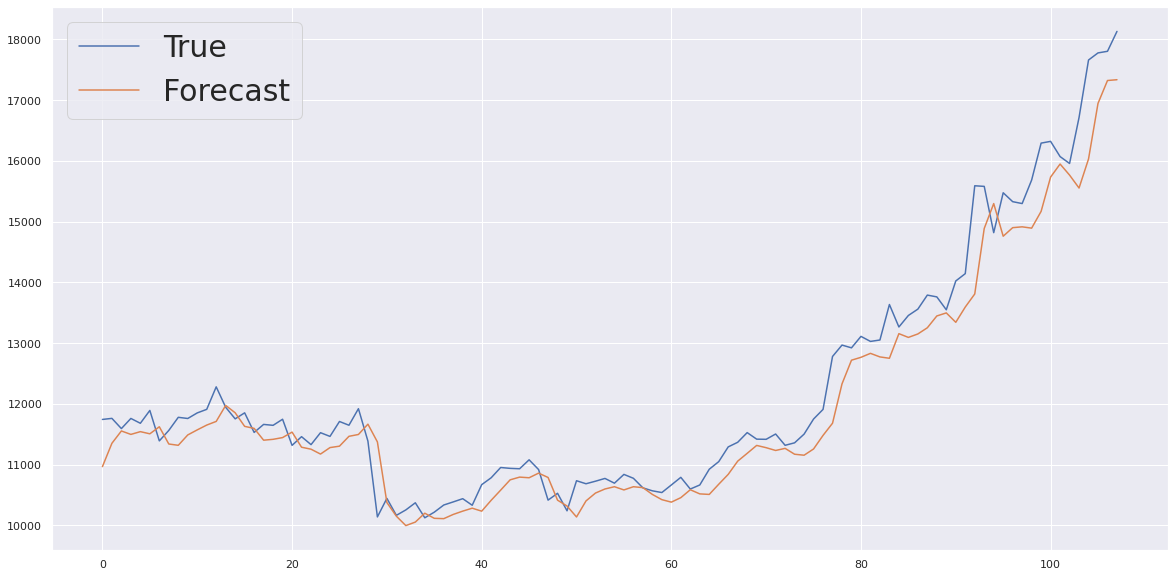

In [65]:
plt.plot(inv_y,label='True')
plt.plot(inv_yhat,label='Forecast')
fig_size=(20,10)
plt.rcParams["figure.figsize"] = fig_size
plt.legend(loc='best',prop={'size': 30}) 
plt.show()